# Indexing
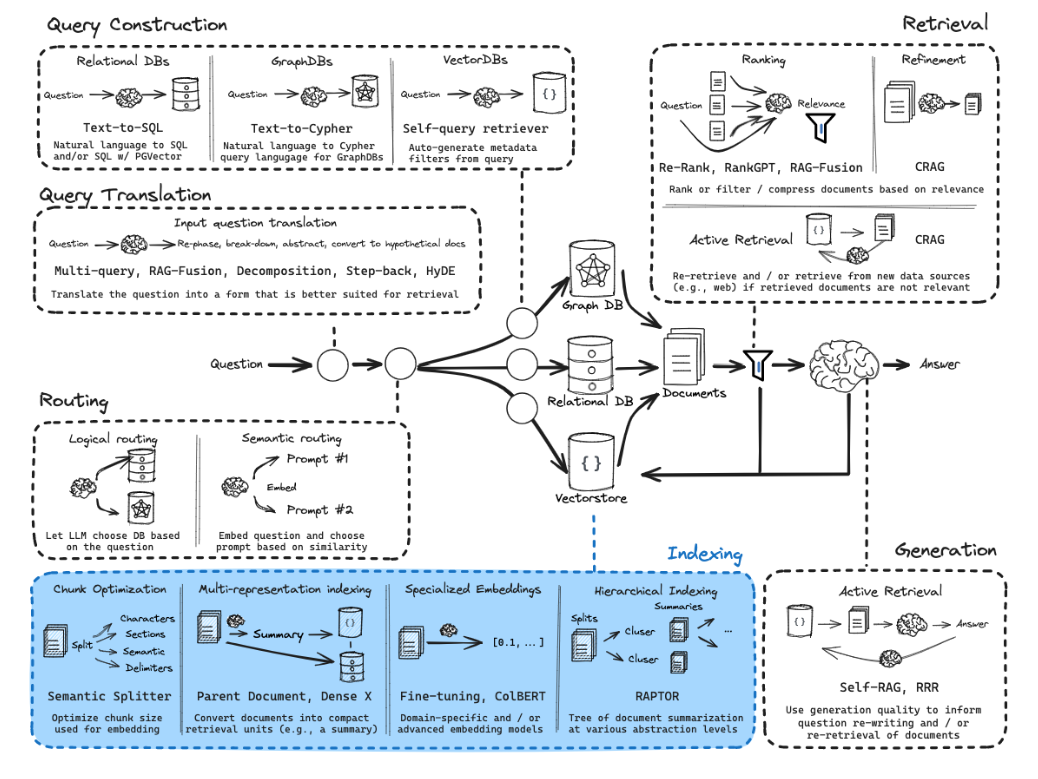

In [3]:
! pip install langchain_community tiktoken langchain-google-genai langchainhub chromadb langchain youtube-transcript-api pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.9/18.9 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.4 MB/s eta 0:00:00
   ━━━

In [ ]:
import os
os.environ['LANGCHAIN_TRACING_V2']='true'
os.environ['LANGCHAIN_ENDPOINT']='https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY']='LANGCHAIN_API_KEY'
os.environ['GOOGLE_API_KEY']='GOOGLE_API_KEY'

# Multi Representation Indexing
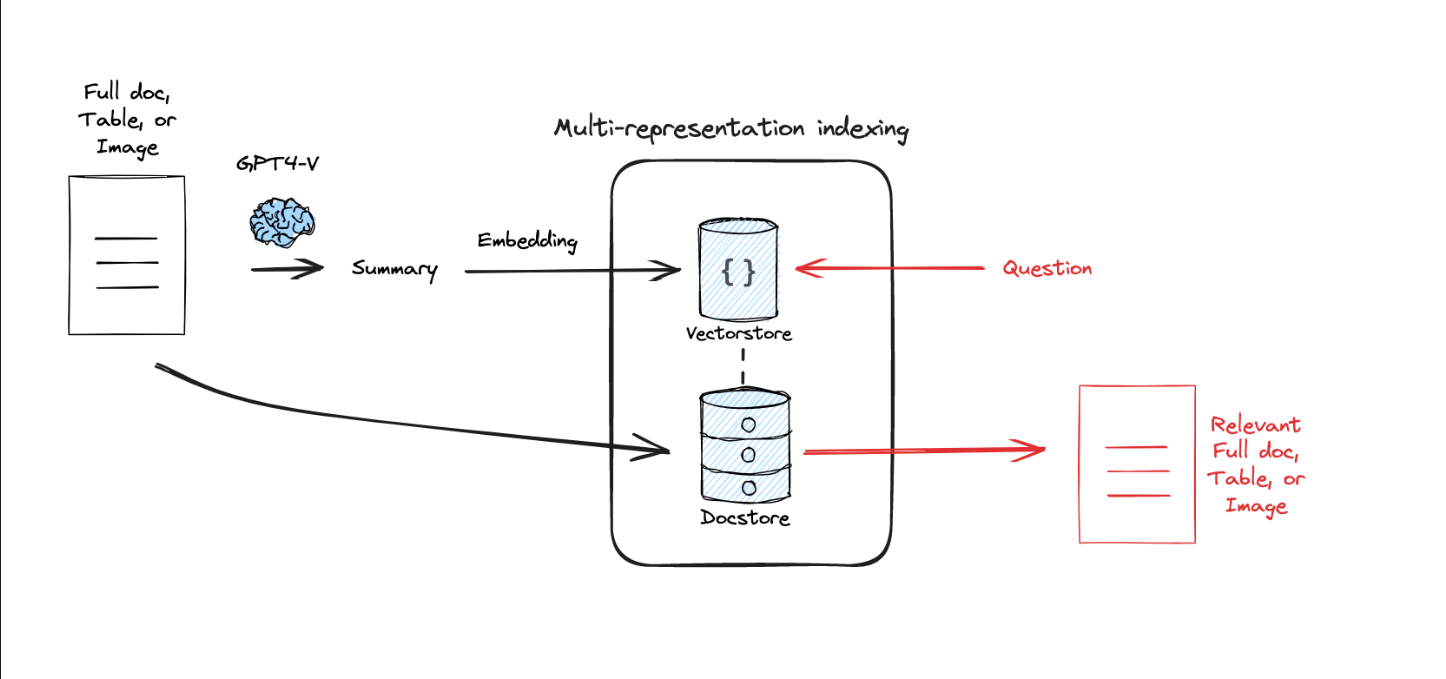

* Multi-Representation Indexing means creating multiple types of indexes for a same data, each representing the data in different format. This approach allows you to perform efficient search, retrieval and analysis based on different perspectives of the data

* Different types of queries require different types of Indexes
1. Text search (keyword-based)
2. Semantic search (meaning-based)
3. Vector search(embeddings-based)

# Semantic Search (meaning-based)
1. Summary Creation-
* For each document we create a `short summary`. This summary will capture the core idea of the document. Each summary is given a `unique ID`(UUID) that links it to the document.
2. Indexing Summaries-
* These summaries are vectorized using embedding model. The vector representations are stored in the `vectorstore(Chroma)`. This means we can perform fast semantic search on these summaries without scanning the full documents.
3. Direct Document Storage-
* The full original documents are stored separately in `InMemoryByteStore`. Each document is stored using same UUID that assigned to its summary. This will allows us to directly fetch the documents once a matching summary is found.

In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

loader=WebBaseLoader('https://lilianweng.github.io/posts/2023-06-23-agent/')
docs=loader.load()

loader=WebBaseLoader('https://lilianweng.github.io/posts/2024-02-05-human-data-quality/')
docs.extend(loader.load())

In [3]:
import uuid # for generating unique identifiers
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.documents import Document


chain=(
    # Extract the page_content from document from a document object.
    {'doc':lambda x:x.page_content}
    | ChatPromptTemplate.from_template('Summarize the following document:\n\n{doc}')
    | ChatGoogleGenerativeAI(model='gemini-1.5-flash')
    | StrOutputParser()
)

summaries=chain.batch(docs,{'max_concurrancy':5})

In [4]:
from langchain.storage import InMemoryByteStore
from langchain_community.vectorstores import Chroma
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.retrievers import MultiVectorRetriever

# The vector store to use index
vectorstore=Chroma(collection_name='summaries',embedding_function=GoogleGenerativeAIEmbeddings(model='models/embedding-001'))

# The storage layer for parent document - Stores full original document
store=InMemoryByteStore()
# This is the key that will be used to link the summary documents
id_key='doc_id'

# The retriever
retriever=MultiVectorRetriever(
    vectorstore=vectorstore,
    byte_store=store,
    id_key=id_key
)

# Creates a list of unique identifiers for each document in the docs list.
doc_ids=  [str(uuid.uuid4())for _ in docs]


# Create a list of Document objects, each representing a summary of a document.
summary_docs=[Document(page_content=s,metadata={id_key:doc_ids[i]} )
              for i,s in enumerate(summaries)
              ]

# Add summarized documents to the vector store.
retriever.vectorstore.add_documents(summary_docs)
# Storing full documents in the Byte Store
retriever.docstore.mset(list(zip(doc_ids,docs)))


<ipython-input-4-699d76e7ca42>:7: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore=Chroma(collection_name='summaries',embedding_function=GoogleGenerativeAIEmbeddings(model='models/embedding-001'))


In [5]:
query="Memory in agents"
sub_docs=vectorstore.similarity_search(query,k=1)
sub_docs[0]

Document(metadata={'doc_id': '8024425a-192b-4078-8fb5-57472bdfe209'}, page_content='This blog post by Lilian Weng explores Large Language Model (LLM)-powered autonomous agents.  It details the key components of such agents: planning (including task decomposition and self-reflection using techniques like Chain of Thought, Tree of Thoughts, ReAct, Reflexion, Chain of Hindsight, and Algorithm Distillation), memory (short-term via in-context learning and long-term through external vector stores and Maximum Inner Product Search (MIPS) algorithms like LSH, ANNOY, HNSW, FAISS, and ScaNN), and tool use (leveraging external APIs and other models).\n\nThe post examines several case studies, including ChemCrow (a scientific discovery agent), Generative Agents (a simulation of interacting virtual characters), and proof-of-concept examples like AutoGPT and GPT-Engineer.  It also discusses challenges in building these agents, such as the limitations of finite context length, difficulties in long-ter

In [7]:
retrieved_docs=retriever.get_relevant_documents(query,n_results=1)
retrieved_docs[0].page_content

'\n\n\n\n\n\nLLM Powered Autonomous Agents | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n|\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\n\n\n\n\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\n \n\n\nTable of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase Studies\n\nScientific Discovery Agent\n\nGenerative Agents Simulation\n\nProof-of-Concept Examples\n\n\nChallenges\n\nCitation\n\nReferences\n\n\n\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The

# Text Search ( keyword based) -- Recursive Abstractive Processing for Tree-Organized Retrieval.
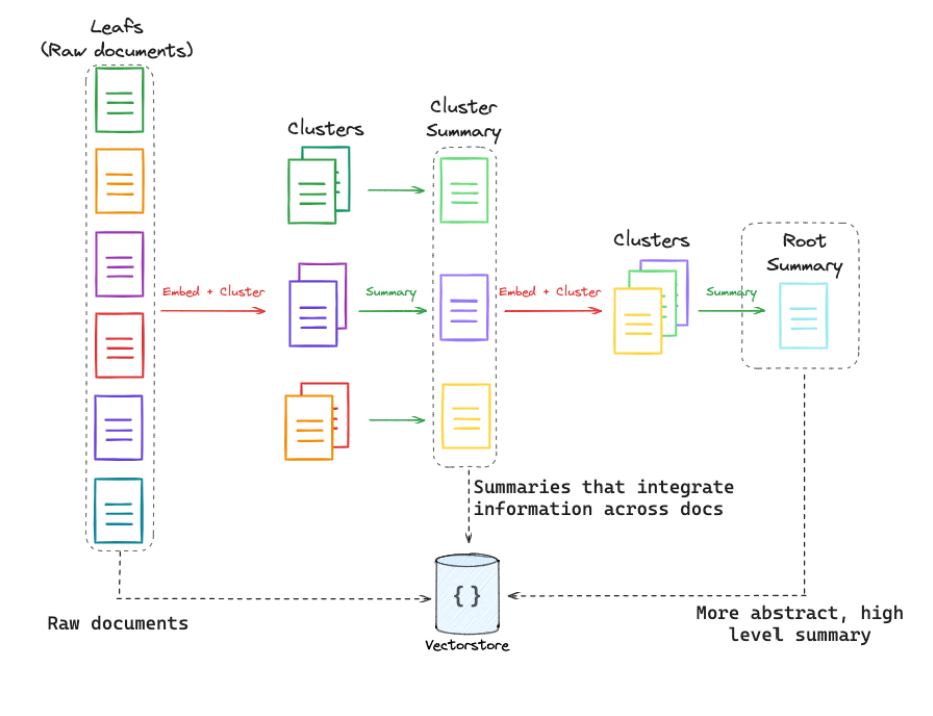


## The RAPTOR paper presents an interesting approaching for indexing and retrieval of documents:

* The leafs are a set of starting documents
* Leafs are embedded and clustered
* Clusters are then summarized into higher level (more abstract) consolidations of information across similar documents
* This process is done recursivly, resulting in a "tree" going from raw docs (leafs) to more abstract summaries.

We can applying this at varying scales; leafs can be:

* Text chunks from a single doc (as shown in the paper)
* Full docs (as we show below)
* With longer context LLMs, it's possible to perform this over full documents.

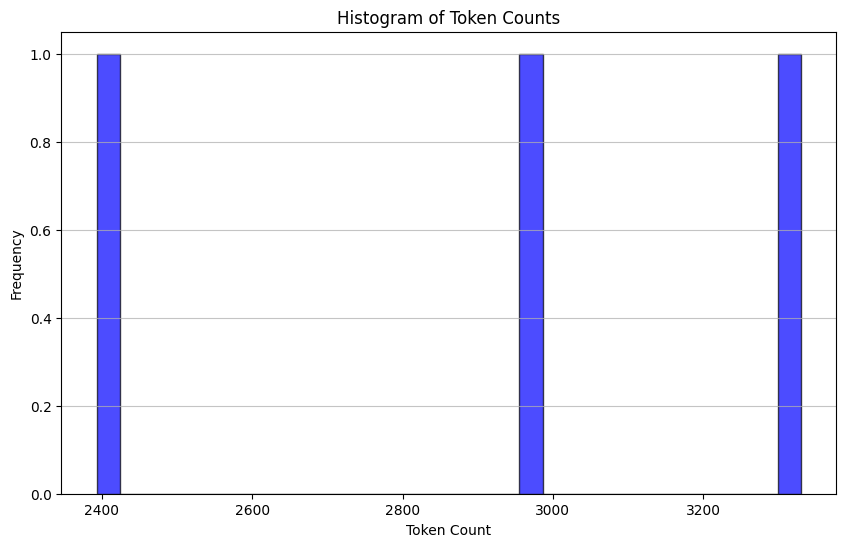

In [10]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as Soup
import tiktoken
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader

def num_tokens_from_string(string:str,encoding_name:str)->int:
  """Returns number of tokens from string"""
  encoding=tiktoken.get_encoding(encoding_name)
  num_tokens=len(encoding.encode(string))
  return num_tokens


# LCEL docs
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# LCEL w/ PydanticOutputParser (outside the primary LCEL docs)
url = "https://python.langchain.com/docs/concepts/output_parsers/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# Retriever
url = "https://python.langchain.com/docs/concepts/retrievers/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# Doc texts
docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

# Calculate the number of tokens for each document
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show()


In [11]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 8683


In [12]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size=2000
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=chunk_size,chunk_overlap=0)
texts_split=text_splitter.split_text(concatenated_content)

In [15]:
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings

embd=GoogleGenerativeAIEmbeddings(model='models/embedding-001')
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash',temperature=0)



#Tree Constrution
## The clustering approach in tree construction includes a few interesting ideas.

1. GMM (Gaussian Mixture Model)

* Model the distribution of data points across different clusters
* Optimal number of clusters by evaluating the model's Bayesian Information Criterion (BIC)
UMAP (Uniform Manifold Approximation and Projection)

2. Supports clustering
* Reduces the dimensionality of high-dimensional data
* UMAP helps to highlight the natural grouping of data points based on their similarities

3. Local and Global Clustering
* Used to analyze data at different scales
* Both fine-grained and broader patterns within the data are captured effectively

4. Thresholding

* Apply in the context of GMM to determine cluster membership
* Based on the probability distribution (assignment of data points to ≥ 1 cluster)

In [14]:
from typing import Dict, List, Optional, Tuple
import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224

1. Embedding Texts-
 Convert a list of documents into vector representations using a model

2. Global Clustering-
Use UMAP(for dimensionality reduction) and Gaussian Mixture Model(GMM) to perform global clustering of these embeddings.

3. Local CLustering-
Within each global cluster, it perform local clustering. This creates a hierarchical structure.

4. Recursive Summarization-
For each cluster, it generates a summary using a language model. These summaries are re-clustered and summarized again.
5. Hierarchical Output-
Produce a tree structure


In [16]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224

# This helps to capture the overall structure of the document space.
def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters



def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Language doc.

    LangChain Expression Language provides a way to compose chain in LangChain.

    Give a detailed summary of the documentation provided.

    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [17]:
# Build tree
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 1 clusters--


In [20]:
from langchain_chroma import Chroma

# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

In [21]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

# Question
rag_chain.invoke("How to define a RAG chain? Give me a specific code example.")

'A RAG chain in LangChain is defined using the LangChain Expression Language (LCEL), a declarative approach to building chains of operations.  LCEL allows for optimized parallel execution and asynchronous support.  A simple example might be `chain = retriever | llm | output_parser`, sequentially using a retriever, LLM, and output parser.'

# Semantic Search (meaning based)-
Each token(word) in the text is converted into a contextually rich vector.

In [ ]:
! pip install -U ragatouille

In [ ]:
from ragatouille import RAGPretrainedModel
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

In [ ]:
import requests

def get_wikipedia_page(title: str):
    """
    Retrieve the full text content of a Wikipedia page.

    :param title: str - Title of the Wikipedia page.
    :return: str - Full text content of the page as raw string.
    """
    # Wikipedia API endpoint
    URL = "https://en.wikipedia.org/w/api.php"

    # Parameters for the API request
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {"User-Agent": "RAGatouille_tutorial/0.0.1 (ben@clavie.eu)"}

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    return page["extract"] if "extract" in page else None

full_document = get_wikipedia_page("Hayao_Miyazaki")

In [ ]:
RAG.index(
    collection=[full_document],
    index_name="Miyazaki-123",
    max_document_length=180,
    split_documents=True,
)